In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

file_path = 'train/TRAIN_A.csv'
data = pd.read_csv(file_path)

print(data.head())

         timestamp     Q1         Q2         Q3    Q4     Q5  M1  M2  M3  M4  \
0  2024-05-27 0:00  17880  37151.001  24834.001  6321  85828   0   0   0   1   
1  2024-05-27 0:01  17970  37069.001  25016.001  6367  85212   0   0   0   1   
2  2024-05-27 0:02  17280  37345.000  24462.000  6431  85655   0   0   0   1   
3  2024-05-27 0:03  17280  37345.000  24462.000  6431  85619   0   0   0   1   
4  2024-05-27 0:04  17920  37075.000  24896.001  6206  85619   0   0   0   1   

   ...  P17_flag  P18_flag  P19_flag  P20_flag  P21_flag  P22_flag  P23_flag  \
0  ...         0         0         0         0         0         0         0   
1  ...         0         0         0         0         0         0         0   
2  ...         0         0         0         0         0         0         0   
3  ...         0         0         0         0         0         0         0   
4  ...         0         0         0         0         0         0         0   

   P24_flag  P25_flag  P26_flag  
0   

Original data shape: (44101, 73)
Data shape for last 300 rows: (300, 73)


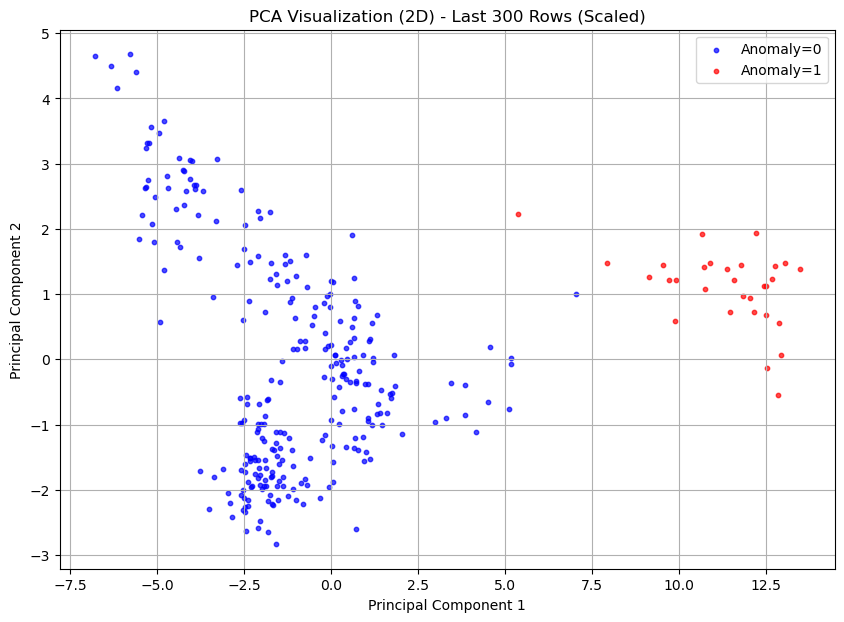

Data shape for last 400 rows: (400, 73)


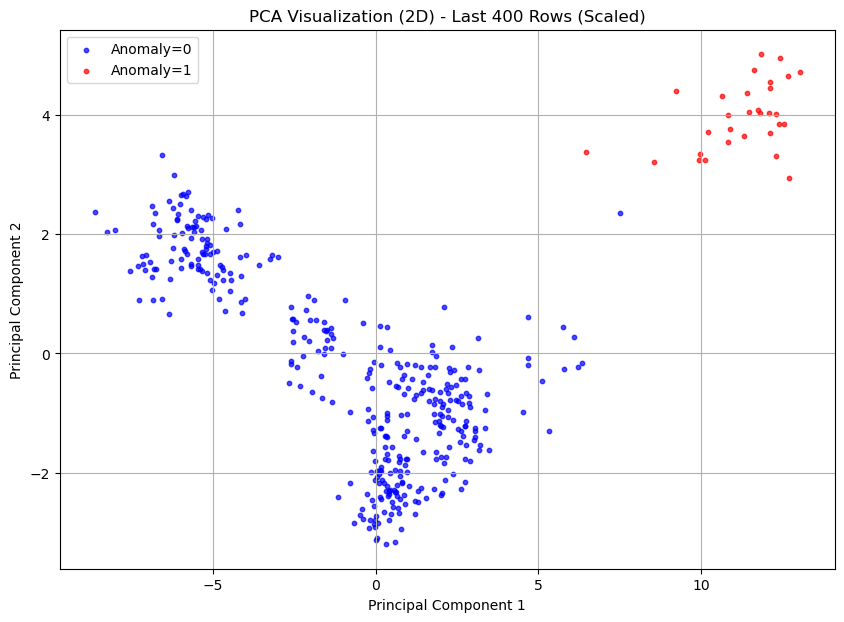

Data shape for last 500 rows: (500, 73)


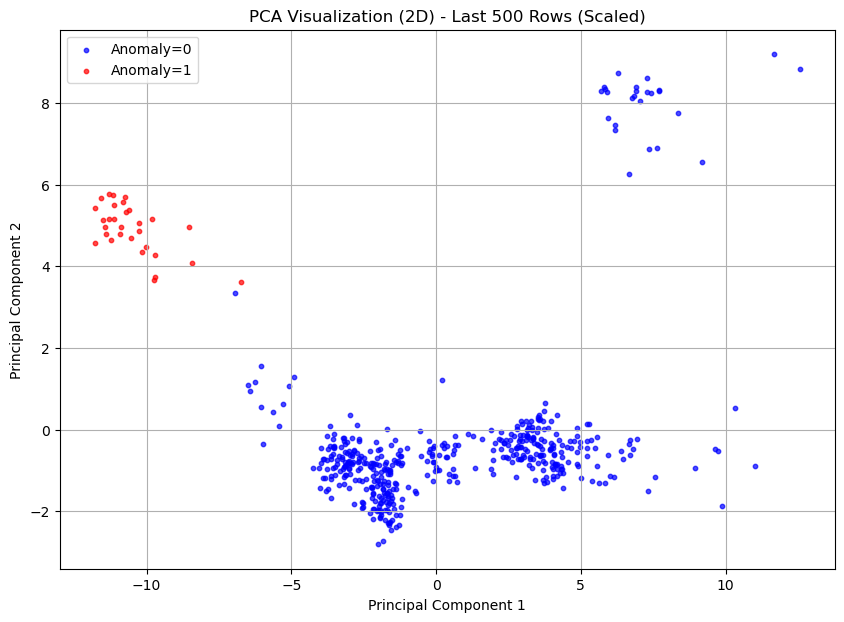

In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Load the data
file_path = 'train/TRAIN_A.csv'
data = pd.read_csv(file_path)

print("Original data shape:", data.shape)

# Step 2: Define a list of row counts to analyze
row_counts = [300, 400, 500]

# Step 3: Iterate through each row count and perform PCA
for count in row_counts:
    # Select the last `count` rows
    data_subset = data.tail(count)
    print(f"Data shape for last {count} rows:", data_subset.shape)

    # Select Q1~Q5 and P1~P26 columns for PCA
    columns_for_pca = [col for col in data_subset.columns if col.startswith('Q') or col.startswith('P')]
    data_for_pca = data_subset[columns_for_pca]

    # Check for missing values and handle them (e.g., fill with mean)
    if data_for_pca.isnull().sum().sum() > 0:
        data_for_pca = data_for_pca.fillna(data_for_pca.mean())

    # Scale the data
    scaler = StandardScaler()
    data_for_pca_scaled = scaler.fit_transform(data_for_pca)

    # Apply PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data_for_pca_scaled)

    # Extract anomaly column for coloring
    anomaly = data_subset['anomaly']

    # Plot the PCA results
    plt.figure(figsize=(10, 7))
    colors = ['blue', 'red']  # Blue for anomaly=0, Red for anomaly=1
    for anomaly_value in [0, 1]:
        mask = anomaly == anomaly_value
        plt.scatter(pca_result[mask, 0], pca_result[mask, 1],
                    label=f"Anomaly={anomaly_value}", alpha=0.7, s=10, c=colors[anomaly_value])

    plt.title(f'PCA Visualization (2D) - Last {count} Rows (Scaled)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

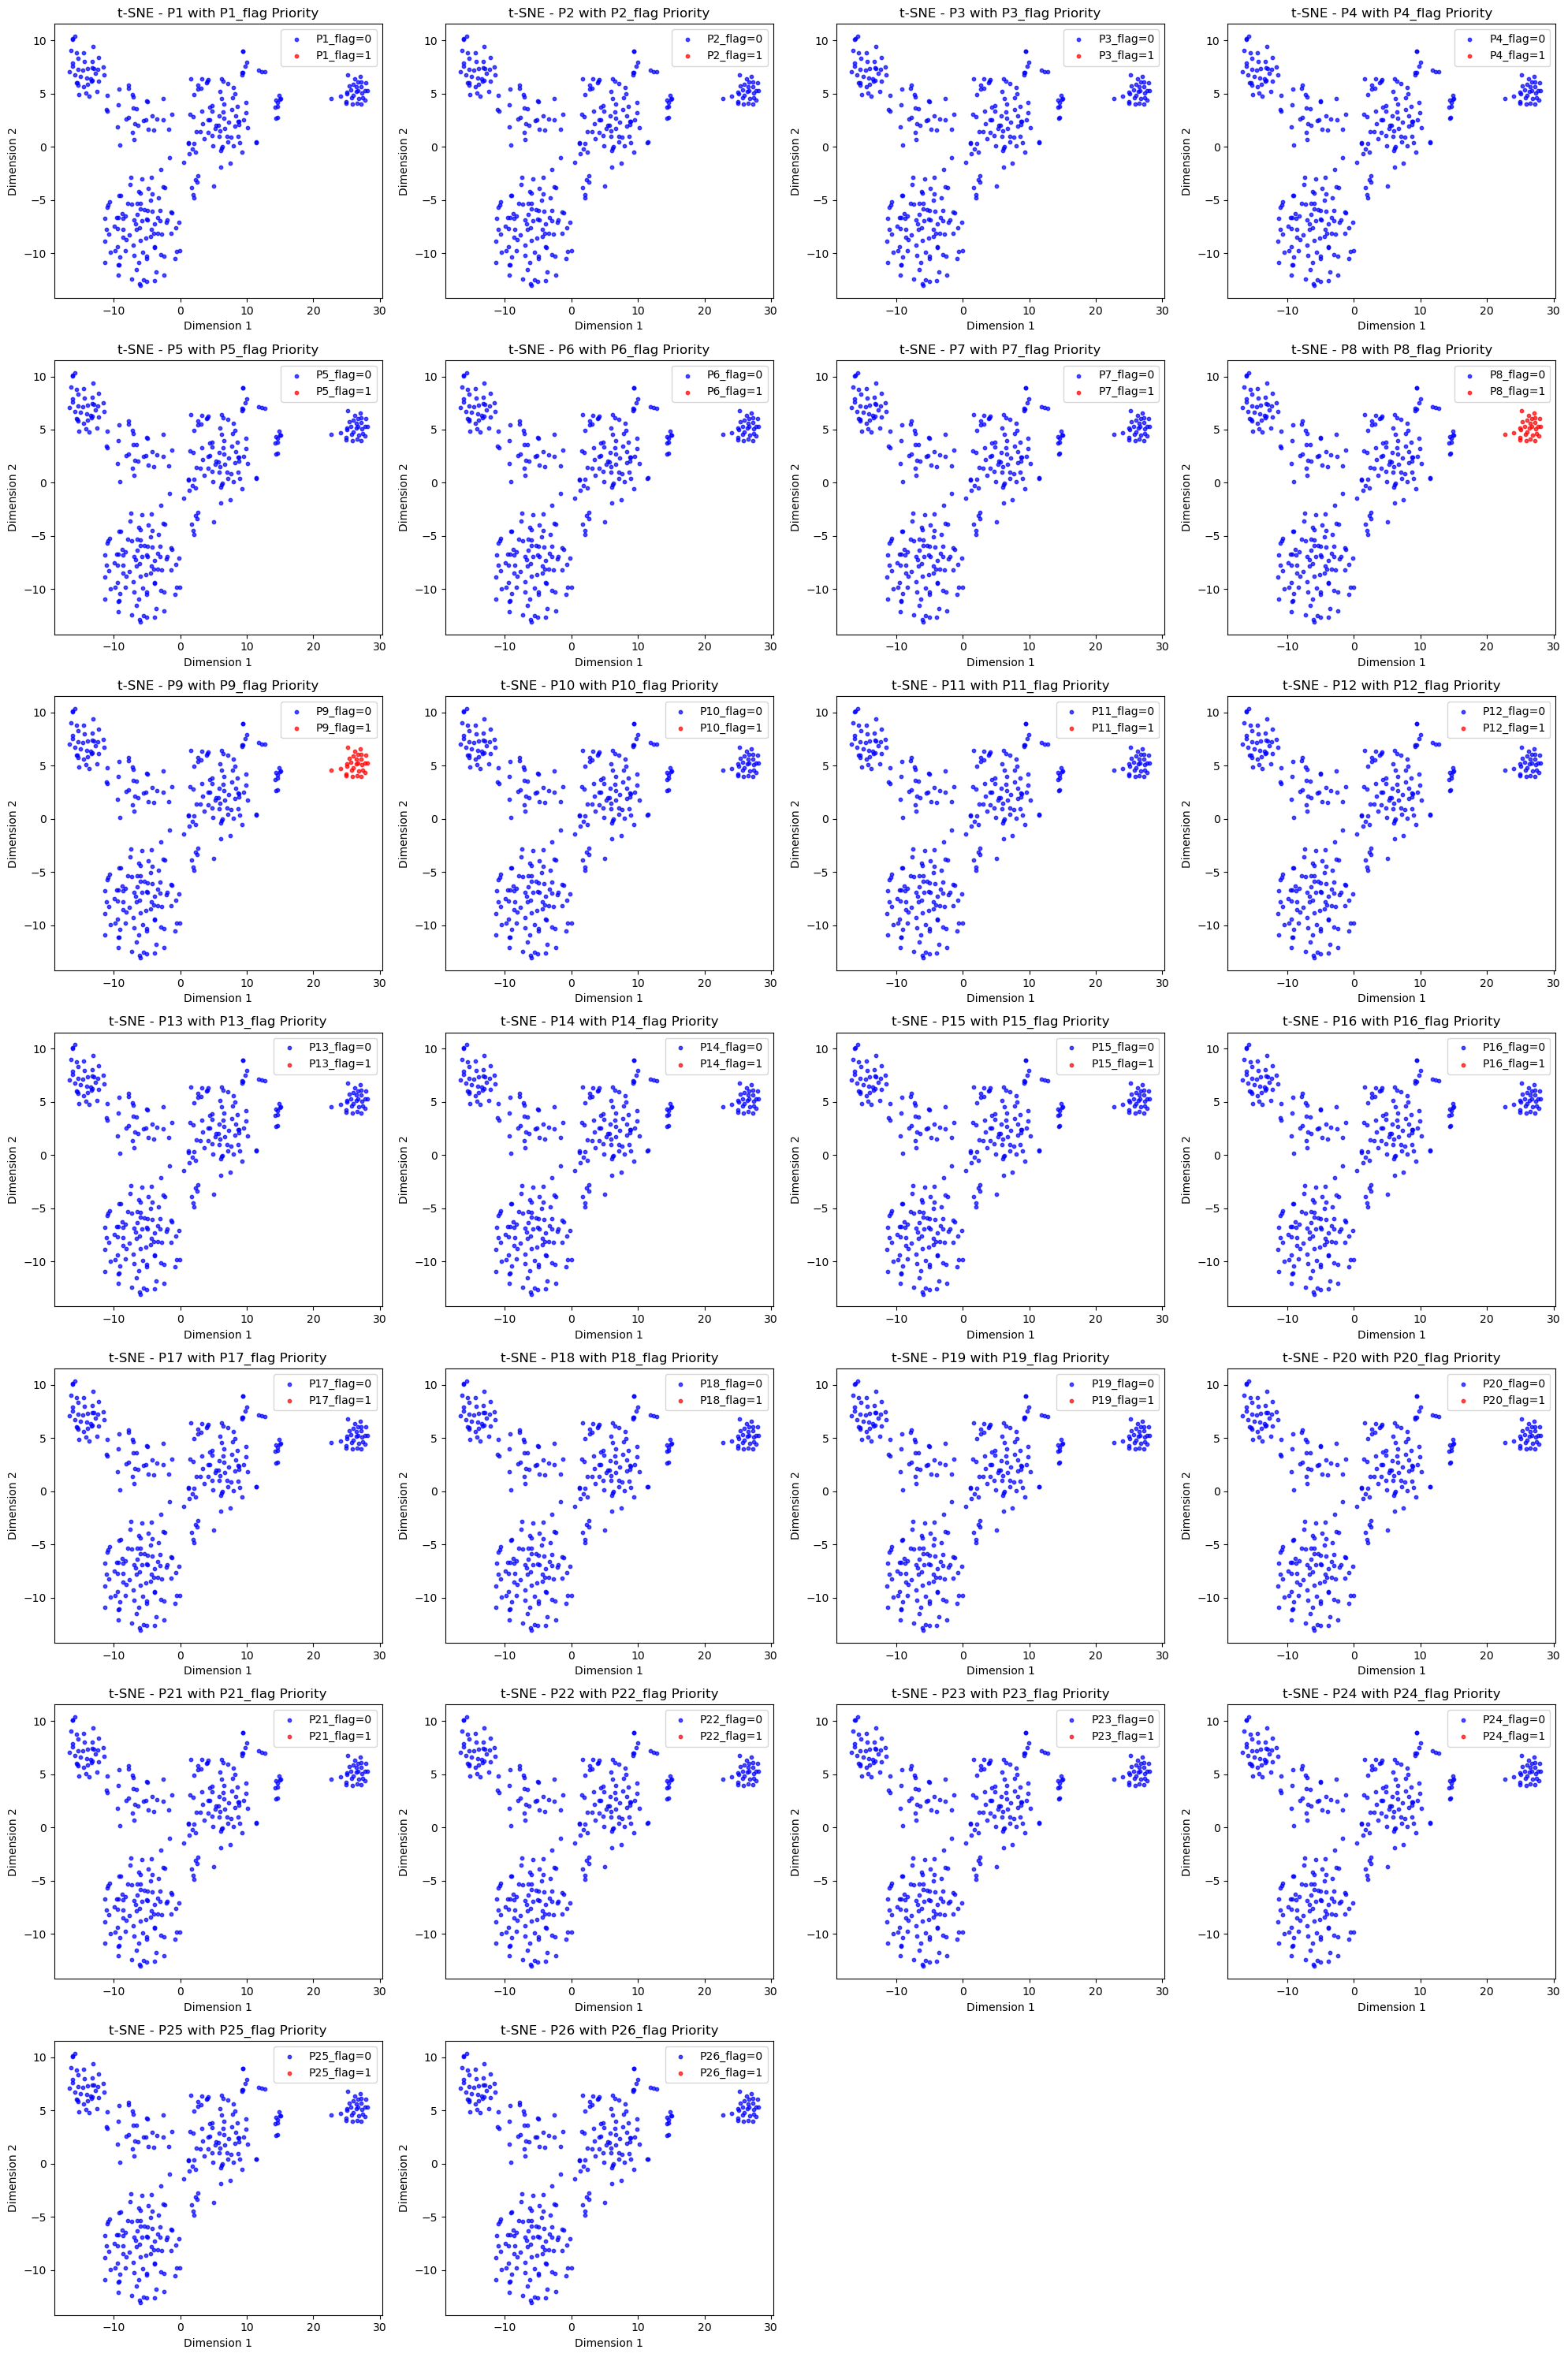

In [27]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: 데이터 로드
file_path = 'train/TRAIN_A.csv'
data = pd.read_csv(file_path)

# Step 2: 마지막 300개 데이터 선택
data = data.tail(300)

# Step 3: 문자열 열 처리
non_numeric_columns = data.select_dtypes(include=['object']).columns

if 'timestamp' in non_numeric_columns:
    data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')
    data['hour'] = data['timestamp'].dt.hour
    data['minute'] = data['timestamp'].dt.minute
    data['day_of_week'] = data['timestamp'].dt.dayofweek

# PCA에 사용할 P1~P26 열 정의
p_columns = [col for col in data.columns if col.startswith('P')]
p_flag_columns = [f'P{i}_flag' for i in range(1, 27)]

# Step 4: 차원 축소 및 시각화 반복
plt.figure(figsize=(20, 30))
scaler = StandardScaler()

for idx, (p_col, p_flag_col) in enumerate(zip(p_columns, p_flag_columns)):
    if p_col not in data.columns or p_flag_col not in data.columns:
        print(f"Skipping {p_col} or {p_flag_col} (not in data)")
        continue

    # P1~P26 데이터 선택
    selected_data = data[p_columns].fillna(data.mean())

    # 특정 P{i}에 가중치 부여
    weights = np.ones(selected_data.shape[1])  # 모든 피처에 기본 가중치 1
    target_index = p_columns.index(p_col)     # P{i}의 인덱스 확인
    weights[target_index] = 1
    weighted_data = selected_data * weights

    # 스케일링
    weighted_data_scaled = scaler.fit_transform(weighted_data)

    # t-SNE로 차원 축소
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_result = tsne.fit_transform(weighted_data_scaled)

    # 현재 flag 값 사용
    flags = data[p_flag_col]
    colors = ['blue', 'red']  # 0: 파란색, 1: 빨간색

    # t-SNE 시각화
    plt.subplot(7, 4, idx + 1)
    for flag_value in [0, 1]:
        mask = flags == flag_value
        plt.scatter(tsne_result[mask, 0], tsne_result[mask, 1],
                    label=f"{p_flag_col}={flag_value}", alpha=0.7, s=10, c=colors[flag_value])
    plt.title(f"t-SNE - {p_col} with {p_flag_col} Priority")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()

plt.tight_layout()
plt.show()

In [29]:
tsne_result

array([[-1.57897549e+01,  1.03655052e+01],
       [-1.61714554e+01,  1.01184435e+01],
       [-1.61973763e+01,  1.00607347e+01],
       [-1.44943800e+01,  8.83133125e+00],
       [-1.49867239e+01,  6.59350252e+00],
       [-1.64633026e+01,  9.02506828e+00],
       [-1.53829851e+01,  5.80365992e+00],
       [-1.56141253e+01,  8.79131126e+00],
       [-1.43600559e+01,  7.98681641e+00],
       [-1.53279696e+01,  8.32161140e+00],
       [-1.40879030e+01,  6.46875477e+00],
       [-1.39532022e+01,  5.87534142e+00],
       [-1.30932198e+01,  9.38407516e+00],
       [-1.52209015e+01,  4.86027670e+00],
       [-1.44854708e+01,  5.60996008e+00],
       [-1.33463163e+01,  6.12638044e+00],
       [-1.39810734e+01,  7.32558680e+00],
       [-1.34678926e+01,  6.36260653e+00],
       [-1.31911659e+01,  6.23270226e+00],
       [-1.23565378e+01,  7.23934317e+00],
       [-1.67112942e+01,  7.06777096e+00],
       [-1.32035990e+01,  7.41563845e+00],
       [-1.27243996e+01,  6.87561560e+00],
       [-1.

In [33]:
data

,timestamp,Q1,Q2,Q3,Q4,Q5,M1,M2,M3,M4,...,P20_flag,P21_flag,P22_flag,P23_flag,P24_flag,P25_flag,P26_flag,hour,minute,day_of_week
43801,2024-06-26 10:01:00,17640,32536.001,41856.001,5375,95184,0,0,0,1,...,0,0,0,0,0,0,0,10,1,2
43802,2024-06-26 10:02:00,18440,32195.000,40809.001,5225,94480,0,0,0,1,...,0,0,0,0,0,0,0,10,2,2
43803,2024-06-26 10:03:00,18440,32195.000,40809.001,5225,94659,0,0,0,1,...,0,0,0,0,0,0,0,10,3,2
43804,2024-06-26 10:04:00,18380,32390.000,40454.001,5259,94659,0,0,0,1,...,0,0,0,0,0,0,0,10,4,2
43805,2024-06-26 10:05:00,18380,32390.000,40454.001,5259,95318,0,0,0,1,...,0,0,0,0,0,0,0,10,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44096,2024-06-26 14:56:00,17610,32767.000,41071.001,6364,97783,0,0,0,1,...,0,0,0,0,0,0,0,14,56,2
44097,2024-06-26 14:57:00,17490,32866.001,40488.000,6469,96785,0,0,0,1,...,0,0,0,0,0,0,0,14,57,2
44098,2024-06-26 14:58:00,17490,32866.001,40488.000,6469,97707,0,0,0,1,...,0,0,0,0,0,0,0,14,58,2
44099,2024-06-26 14:59:00,18300,32646.001,41702.002,6616,97707,0,0,0,1,...,0,0,0,0,0,0,0,14,59,2


In [37]:
columns_to_keep = [f'P{i}' for i in range(1, 27)]

data = data[columns_to_keep]

print(data.head())

           P1     P2      P3      P4      P5      P6      P7      P8      P9  \
43801  3.3489  3.261  0.8438  0.8081  1.0575  1.0378  3.9025  0.1603  0.1322   
43802  3.3489  3.261  0.8288  0.7837  1.0650  1.0519  3.9088  0.1575  0.1359   
43803  3.3489  3.261  0.8288  0.7837  1.0650  1.0519  3.9088  0.1575  0.1359   
43804  3.3434  3.261  0.8288  0.7819  1.0650  1.0509  3.9075  0.1453  0.1416   
43805  3.3434  3.261  0.8288  0.7819  1.0650  1.0509  3.9075  0.1453  0.1416   

          P10  ...     P17     P18     P19     P20     P21     P22     P23  \
43801  5.5631  ...  3.3950  2.2438  2.2287  2.7600  2.8025  2.8000  2.7912   
43802  5.5706  ...  3.3788  2.2513  2.2462  2.7775  2.8212  2.8163  2.8200   
43803  5.5706  ...  3.3825  2.2750  2.2475  2.7725  2.8225  2.8400  2.8263   
43804  5.5481  ...  3.3325  2.2587  2.2500  2.7287  2.7887  2.7775  2.7925   
43805  5.5481  ...  3.2825  2.2662  2.2650  2.7362  2.7938  2.7725  2.7875   

          P24     P25     P26  
43801  2.5844  2.4

In [39]:
data

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26
43801,3.3489,3.261,0.8438,0.8081,1.0575,1.0378,3.9025,0.1603,0.1322,5.5631,...,3.3950,2.2438,2.2287,2.7600,2.8025,2.8000,2.7912,2.5844,2.4987,2.4575
43802,3.3489,3.261,0.8288,0.7837,1.0650,1.0519,3.9088,0.1575,0.1359,5.5706,...,3.3788,2.2513,2.2462,2.7775,2.8212,2.8163,2.8200,2.5694,2.4962,2.4519
43803,3.3489,3.261,0.8288,0.7837,1.0650,1.0519,3.9088,0.1575,0.1359,5.5706,...,3.3825,2.2750,2.2475,2.7725,2.8225,2.8400,2.8263,2.5700,2.5069,2.4556
43804,3.3434,3.261,0.8288,0.7819,1.0650,1.0509,3.9075,0.1453,0.1416,5.5481,...,3.3325,2.2587,2.2500,2.7287,2.7887,2.7775,2.7925,2.5700,2.5069,2.4556
43805,3.3434,3.261,0.8288,0.7819,1.0650,1.0509,3.9075,0.1453,0.1416,5.5481,...,3.2825,2.2662,2.2650,2.7362,2.7938,2.7725,2.7875,2.5581,2.5006,2.4531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44096,3.3159,3.239,0.7828,0.7603,1.0266,1.0303,3.8600,0.1200,0.1031,5.5538,...,3.2875,2.2362,2.1875,2.6888,2.7575,2.7575,2.7787,2.5156,2.4262,2.3869
44097,3.3214,3.239,0.7856,0.7613,1.0416,1.0472,3.8612,0.1219,0.1125,5.5397,...,3.3000,2.2500,2.2062,2.7387,2.7462,2.7762,2.7750,2.5094,2.4369,2.3906
44098,3.3214,3.239,0.7856,0.7613,1.0416,1.0472,3.8612,0.1219,0.1125,5.5397,...,3.3075,2.2525,2.2025,2.7000,2.7600,2.7462,2.7475,2.5194,2.4288,2.3850
44099,3.3214,3.239,0.7800,0.7556,1.0472,1.0566,3.8600,0.1219,0.1144,5.5284,...,3.2950,2.2600,2.2175,2.7000,2.7325,2.7625,2.7762,2.5194,2.4288,2.3850


In [45]:
# Step 4: 데이터 스케일링
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Step 5: t-SNE 차원 축소
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(scaled_data)

# Step 6: 새로운 데이터프레임 생성
tsne_df = pd.DataFrame(
    tsne_result, 
    columns=['t-SNE Dimension 1', 't-SNE Dimension 2']
)

print("t-SNE result as DataFrame:")
print(tsne_df.head())

t-SNE result as DataFrame:
   t-SNE Dimension 1  t-SNE Dimension 2
0         -18.373236           3.610081
1         -18.536190           4.056710
2         -18.523613           4.112774
3         -16.449387           3.796087
4         -15.762069           7.571985


In [47]:
tsne_result

array([[-1.83732357e+01,  3.61008096e+00],
       [-1.85361900e+01,  4.05671024e+00],
       [-1.85236130e+01,  4.11277390e+00],
       [-1.64493866e+01,  3.79608703e+00],
       [-1.57620687e+01,  7.57198524e+00],
       [-1.80818577e+01,  5.10782242e+00],
       [-1.51337032e+01,  7.23363495e+00],
       [-1.72946091e+01,  4.74860907e+00],
       [-1.59547567e+01,  4.94335461e+00],
       [-1.68267441e+01,  4.83631086e+00],
       [-1.47601080e+01,  5.75347614e+00],
       [-1.48346262e+01,  5.63729286e+00],
       [-1.35990410e+01,  7.73902273e+00],
       [-1.42528048e+01,  7.27909803e+00],
       [-1.42899218e+01,  6.49375010e+00],
       [-1.42245054e+01,  5.12563944e+00],
       [-1.46765633e+01,  3.81274843e+00],
       [-1.40780468e+01,  5.29169273e+00],
       [-1.38929186e+01,  4.92894363e+00],
       [-1.31206789e+01,  5.17276669e+00],
       [-1.69859333e+01,  6.71042681e+00],
       [-1.49247818e+01,  4.75132418e+00],
       [-1.41059475e+01,  4.14392233e+00],
       [-1.

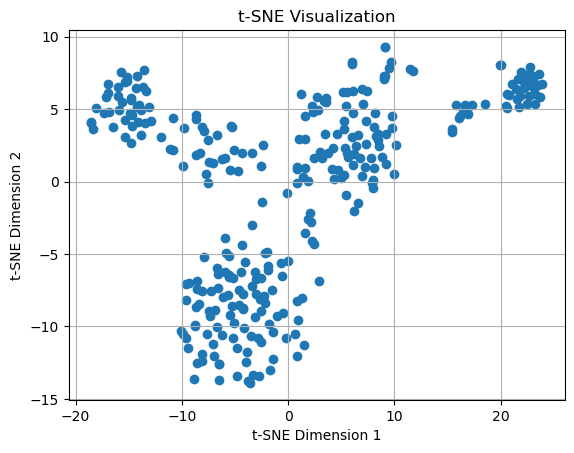

In [55]:
import matplotlib.pyplot as plt

plt.scatter(tsne_df['t-SNE Dimension 1'], tsne_df['t-SNE Dimension 2'])
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()

In [49]:
# tsne_result와 tsne_df 비교
print("Are tsne_result and tsne_df values equal?")
print(np.allclose(tsne_result, tsne_df.values))  # True: 값이 같음

Are tsne_result and tsne_df values equal?
True


In [51]:
tsne_result

array([[-1.83732357e+01,  3.61008096e+00],
       [-1.85361900e+01,  4.05671024e+00],
       [-1.85236130e+01,  4.11277390e+00],
       [-1.64493866e+01,  3.79608703e+00],
       [-1.57620687e+01,  7.57198524e+00],
       [-1.80818577e+01,  5.10782242e+00],
       [-1.51337032e+01,  7.23363495e+00],
       [-1.72946091e+01,  4.74860907e+00],
       [-1.59547567e+01,  4.94335461e+00],
       [-1.68267441e+01,  4.83631086e+00],
       [-1.47601080e+01,  5.75347614e+00],
       [-1.48346262e+01,  5.63729286e+00],
       [-1.35990410e+01,  7.73902273e+00],
       [-1.42528048e+01,  7.27909803e+00],
       [-1.42899218e+01,  6.49375010e+00],
       [-1.42245054e+01,  5.12563944e+00],
       [-1.46765633e+01,  3.81274843e+00],
       [-1.40780468e+01,  5.29169273e+00],
       [-1.38929186e+01,  4.92894363e+00],
       [-1.31206789e+01,  5.17276669e+00],
       [-1.69859333e+01,  6.71042681e+00],
       [-1.49247818e+01,  4.75132418e+00],
       [-1.41059475e+01,  4.14392233e+00],
       [-1.

In [53]:
tsne_df.values

array([[-1.83732357e+01,  3.61008096e+00],
       [-1.85361900e+01,  4.05671024e+00],
       [-1.85236130e+01,  4.11277390e+00],
       [-1.64493866e+01,  3.79608703e+00],
       [-1.57620687e+01,  7.57198524e+00],
       [-1.80818577e+01,  5.10782242e+00],
       [-1.51337032e+01,  7.23363495e+00],
       [-1.72946091e+01,  4.74860907e+00],
       [-1.59547567e+01,  4.94335461e+00],
       [-1.68267441e+01,  4.83631086e+00],
       [-1.47601080e+01,  5.75347614e+00],
       [-1.48346262e+01,  5.63729286e+00],
       [-1.35990410e+01,  7.73902273e+00],
       [-1.42528048e+01,  7.27909803e+00],
       [-1.42899218e+01,  6.49375010e+00],
       [-1.42245054e+01,  5.12563944e+00],
       [-1.46765633e+01,  3.81274843e+00],
       [-1.40780468e+01,  5.29169273e+00],
       [-1.38929186e+01,  4.92894363e+00],
       [-1.31206789e+01,  5.17276669e+00],
       [-1.69859333e+01,  6.71042681e+00],
       [-1.49247818e+01,  4.75132418e+00],
       [-1.41059475e+01,  4.14392233e+00],
       [-1.

### 아 왜 안되는거야 다시 처음부터 할거임.